# Results Analysis

## Imports

In [129]:
!pip install -q pandas seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [130]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

## Definitions

### Constants

In [131]:
RESULT_DIR  = '../results/'

#### Strategies

In [132]:
CLASSIC = {'random_sampling', 'margin_sampling', 'training_utility_sampling', 'density_weighted_sampling', 'expected_error_reduction'}
NEIGHBORHOOD = {'borderline_points_sampling', 'k_disagreeing_neighbors_sampling', 'local_set_cardinality_sampling',
                'ls_radius_sampling', 'intra_extra_ratio_sampling', 'harmfulness_sampling', 'usefulness_sampling'}
LIKELIHOOD = {'class_likelihood_sampling', 'class_likeliood_diff_sampling'}
FEATURE_BASED = {'f1_sampling', 'f2_sampling', 'f3_sampling', 'f4_sampling'}
TREE_BASED = {'disjunct_class_percentage_sampling', 'disjunct_size_sampling', 'tree_depth_pruned_sampling',
              'tree_depth_unpruned_sampling'}
CLASS_BALANCE = {'class_balance_sampling', 'minority_value_sampling'}

In [199]:
ABREV_DICT = {
    'random_sampling': 'Rnd',
    'margin_sampling': 'MS',
    'training_utility_sampling': 'TU',
    'density_weighted_sampling': 'ID',
    'expected_error_reduction': 'EER$_{ent}$',
    'borderline_points_sampling': 'N1I',
    'k_disagreeing_neighbors_sampling': 'kDN',
    'local_set_cardinality_sampling': 'LSCI',
    'ls_radius_sampling': 'LSR',
    'intra_extra_ratio_sampling': r'N2I',
    'harmfulness_sampling': 'H',
    'usefulness_sampling': 'U',
    'class_likelihood_sampling': 'CL',
    'class_likeliood_diff_sampling': 'CLD',
    'f1_sampling': 'F1I',
    'f2_sampling': 'F2I',
    'f3_sampling': 'F3I',
    'f4_sampling': 'F4I',
    'disjunct_class_percentage_sampling': 'DCP',
    'disjunct_size_sampling': 'DS',
    'tree_depth_pruned_sampling': 'TDP',
    'tree_depth_unpruned_sampling': 'TDU',
    'class_balance_sampling': 'CB',
    'minority_value_sampling': 'MV'
}

In [134]:
ABREV_MODEL = {
   'GaussianNB': 'NB',
   'SVC': 'SVM',
   'DecisionTree': 'CART',
   '5NN': '5NN',
}

### Helper Functions

In [135]:
def get_hm_type(x: str):
    if x in CLASSIC: return 'Classic'
    if x in NEIGHBORHOOD: return 'Neighbor-based'
    if x in LIKELIHOOD: return 'Likelihood-based'
    if x in FEATURE_BASED: return 'Feature-based'
    if x in TREE_BASED: return 'Tree-based'
    if x in CLASS_BALANCE: return 'Class-Balance'
        

In [136]:
def sort_curves(x: pd.Index):
    return x.map(lambda y: (not y in CLASSIC,
                            not y in NEIGHBORHOOD,
                            not y in LIKELIHOOD,
                            not y in FEATURE_BASED,
                            not y in TREE_BASED,
                            y))

In [137]:
def get_style(method):
    if method == 'random_sampling':
        return '--'
    elif method in CLASSIC:
        return '-'
    elif method in NEIGHBORHOOD:
        return '^-.'
    elif method in LIKELIHOOD:
        return 's-.'
    elif method in FEATURE_BASED:
        return '*-.'
    elif method in TREE_BASED:
        return 'h-.'
    else:
        return 'd-.'

In [138]:
def show_counts(df, model, ax):
    df = df.loc[:,model,:]
    df.reset_index().strategy.value_counts().sort_index(ascending=False).plot(
        ax=ax, kind='barh', grid=True, title=model, xlim=(0,100), xticks=range(0, 101, 10),
        sharey=True, figsize=(16,8), xlabel='Experiments count')

### Learning Curves

In [139]:
def plot_learning_curves(df, dataset, classifier):
    color_list = sns.color_palette(n_colors=len(df.columns))
    
    local_df = df.loc[(dataset, classifier)].sort_index(key=sort_curves).T
    
    for i, column in enumerate(local_df.columns):
        # Aplica média móvel
        scores = local_df[column].rolling(window=5).mean()
        plt.plot(local_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 markevery=10)

    
    # Ordenação de legenda
    plt.legend(ncol=2)
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid()
   
    # Titulo
    plt.title(dataset)
    plt.xlabel('Query')
    plt.ylabel('f1-score (macro)')

    

In [140]:
def show_all_learning_curves(df, model):

    for dataset in df.index.levels[0]:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', Warning)
        plot_learning_curves(df, dataset=str(dataset), classifier=model)    

        display(plt.gcf())
        
        if input() == 'q':
            break

        clear_output(wait=True)
        plt.close()
    plt.close()

### Ranking Curves

In [141]:
def plot_ranking_curves(data: pd.DataFrame, model:str, group_strategies=False):

    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=False)
    
    mean_rank_df = ranked_df.groupby('strategy').mean().sort_index(key=sort_curves).T

    color_list = sns.color_palette(n_colors=len(mean_rank_df.columns))
    
    for i, column in enumerate(mean_rank_df.columns):
        # Aplica média móvel
        scores = mean_rank_df[column].rolling(window=5, min_periods=1).mean()

        plt.plot(mean_rank_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 linewidth=0.7,
                 markevery=(0.3, 0.2))


    plt.gca().invert_yaxis()
    
    # Ordenação de legenda
    plt.legend(bbox_to_anchor=(1.01,1), ncol=1, shadow=True)

    # Grid
    plt.grid()
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    
   
    # Titulo
    plt.title(f'Ranking Curves ({model})')
    plt.xlabel('Query')
    plt.ylabel('Avg. Rank')

# plot_ranking_curves(df, 'SVC')

In [142]:
def plot_ranks_with_bands(df, ax, model=None, log=False, ):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

    # Plot Bands
    
    for model_name, df in ranked_df_smoothed.groupby('model'):
        color = ax._get_lines.get_next_color()
        ax.fill_between(np.arange(df.shape[1]), df.max(), df.min(),
                        alpha=0.1,
                        color=color)

    
        if model is None:
        # Plot Best Strategy for each model
            best_strategy = auc_series.loc[model_name].idxmax()
            strategy_name = ABREV_DICT[best_strategy]
            label = f'{strategy_name}-{ABREV_MODEL[model_name]}' 
            
            ax.plot(ranked_df_smoothed.loc[model_name, best_strategy],
                    get_style(best_strategy),
                    label=label,
                    markevery=(50,50),
                    linewidth=0.8, color=color)
            
            worst_strategy = auc_series.loc[model_name].idxmin()
            strategy_name = ABREV_DICT[worst_strategy]
            label = f'{strategy_name}-{ABREV_MODEL[model_name]}' 
            ax.plot(ranked_df_smoothed.loc[model_name, worst_strategy],
                     get_style(worst_strategy),
                     label=label,
                     markevery=(50,50),
                     linewidth=0.8, color=color)
    if model:
            
        color_list = sns.color_palette(n_colors=len(ranked_df_smoothed.columns))
    
        for i, (strategy, row) in  enumerate(ranked_df_smoothed.loc[model].iterrows()):
            ax.plot(ranked_df_smoothed.loc[model, strategy],
                    get_style(strategy),
                    label=strategy,
                    color=color_list[i],
                    markevery=(0.3, 0.2),
                    linewidth=0.8)
            
    ax.set_xticks(range(0, 110, 10))
    ax.grid()
    ax.set_xlabel('Queries')
    ax.set_ylabel('Mean Ranking Position')

    if log == True:
        ax.set_xscale('log')
    
        

In [143]:
def plot_group_band(model, ax):
    
    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=False).groupby('strategy').mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    ranked_df_smoothed['type'] = ranked_df_smoothed.index.map(get_hm_type)

    ranked_df_smoothed.set_index('type', append=True, inplace=True)

    ax.grid()

    for (g, foo), marker in zip(ranked_df_smoothed.groupby('type'), ['*', '+', 'd', '^', 'o']):
        color = ax._get_lines.get_next_color()
    
        ax.fill_between(np.arange(foo.shape[1]), foo.max(), foo.min(),
                         alpha=0.3, color=color)
        ax.plot(foo.max(), markevery=(0.3, 0.2), color=color, marker=None, label=g, linewidth=0.8)
        ax.plot(foo.min(), markevery=(0.3, 0.2), color=color, marker=None, linewidth=0.8)

    # ax.invert_yaxis()
    ax.set_title(model)
    
def plot_group_bands(df):
    fig, axs = plt.subplots(2,2, figsize=(9, 6), sharey=True)

    
    for model , ax in zip(df.reset_index().model.unique(), axs.flatten()):
        plot_group_band(model, ax=ax)

    plt.tight_layout()
    
    plt.legend(loc="upper right",bbox_to_anchor=(1.5, 1.5),ncol=1)
    
   

In [144]:
def final_plot(model_name):
    
    fig, axs = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    plot_ranks_with_bands(df,ax=axs, model=model_name, log=False)
    plt.suptitle(model_name)
    plt.tight_layout()

    plt.gca().invert_yaxis()
    plt.legend(loc='upper left', bbox_to_anchor=(1,1.1), ncols=1)

In [145]:
def get_ranks_df(df, model=None ):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')
    
    auc_series.name = 'auc_score'

    model_auc_df = auc_series.loc[model].sort_values(ascending=False).reset_index()
    model_auc_df['group'] = model_auc_df['strategy'].apply(get_hm_type)
    
    return model_auc_df[["strategy", "group", "auc_score"]]


## Data Gathering

In [146]:
RESULT_FILES = !find $RESULT_DIR -type f 

In [147]:
data = {
    os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f, index_col=0).mean(axis='columns')
    for f in RESULT_FILES
}

In [148]:
index_columns = ['dataset', 'model', 'strategy']

In [149]:
df = pd.DataFrame(data).T.reset_index(names='file_name')
df[index_columns] = df.file_name.str.split('#', expand=True)
df = df.set_index(index_columns).drop(columns='file_name')

Remove observações para EER, pois só foram feitas para SVM:

## Data Analysis

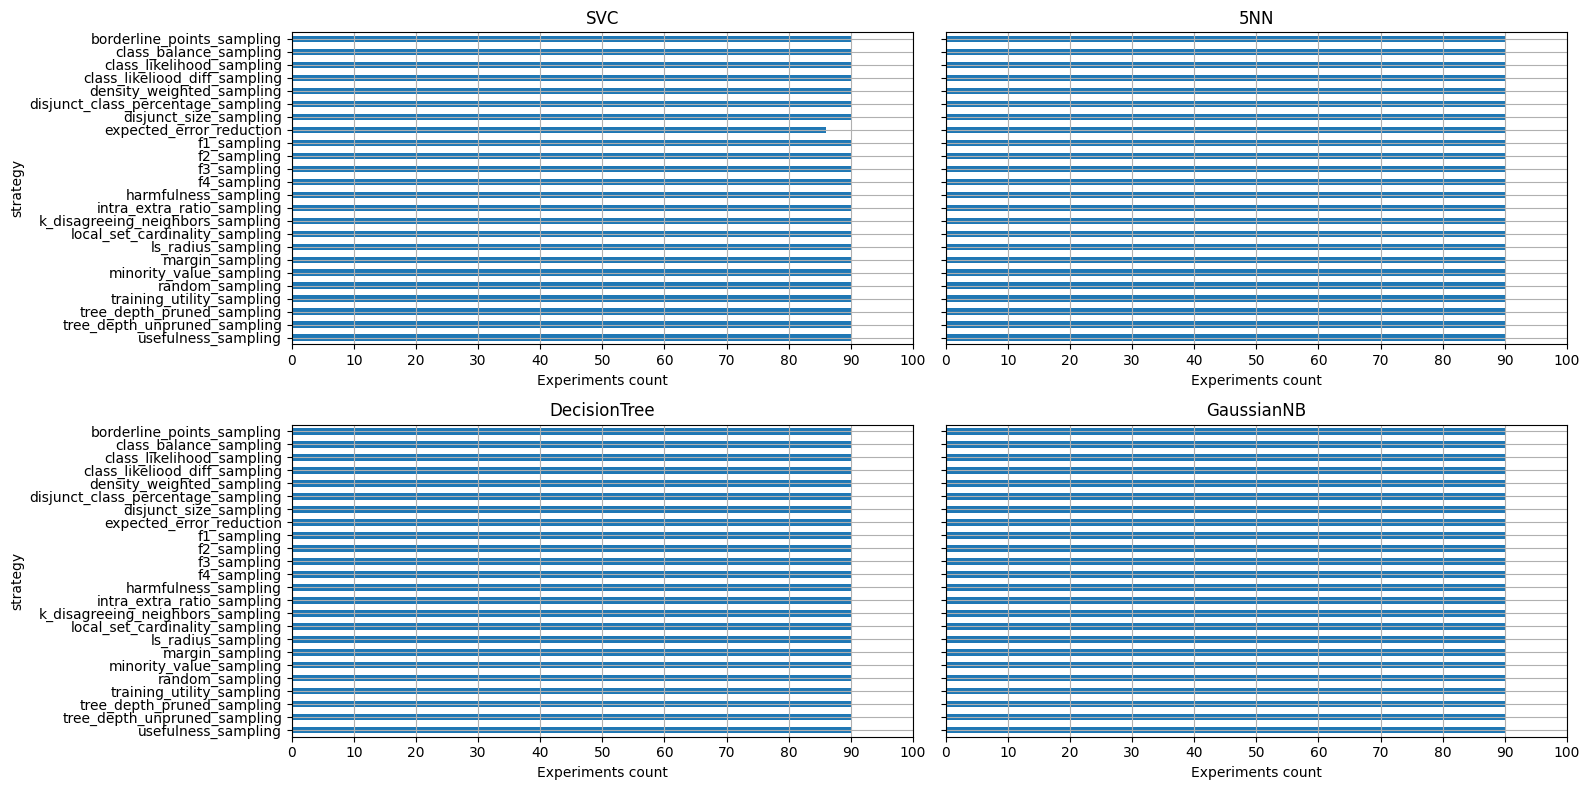

In [150]:
fig, axs = plt.subplots(2,2)

show_counts(df, ax=axs[0, 0], model='SVC')
show_counts(df, ax=axs[0, 1], model='5NN')
show_counts(df, ax=axs[1, 0], model='DecisionTree')
show_counts(df, ax=axs[1, 1], model='GaussianNB')

fig.tight_layout()

## Ranking Curves

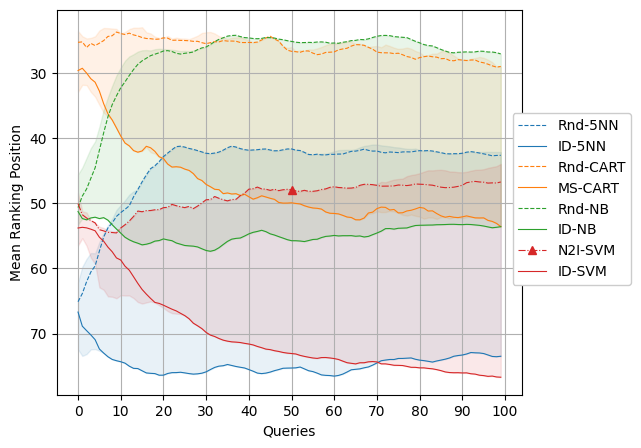

In [151]:
_, ax = plt.subplots(1, 1, figsize=(6,5))
plot_ranks_with_bands(df, ax=ax)
plt.legend(loc='upper right',bbox_to_anchor=(1.25,.75), ncol=1, framealpha=1)
plt.gca().invert_yaxis()

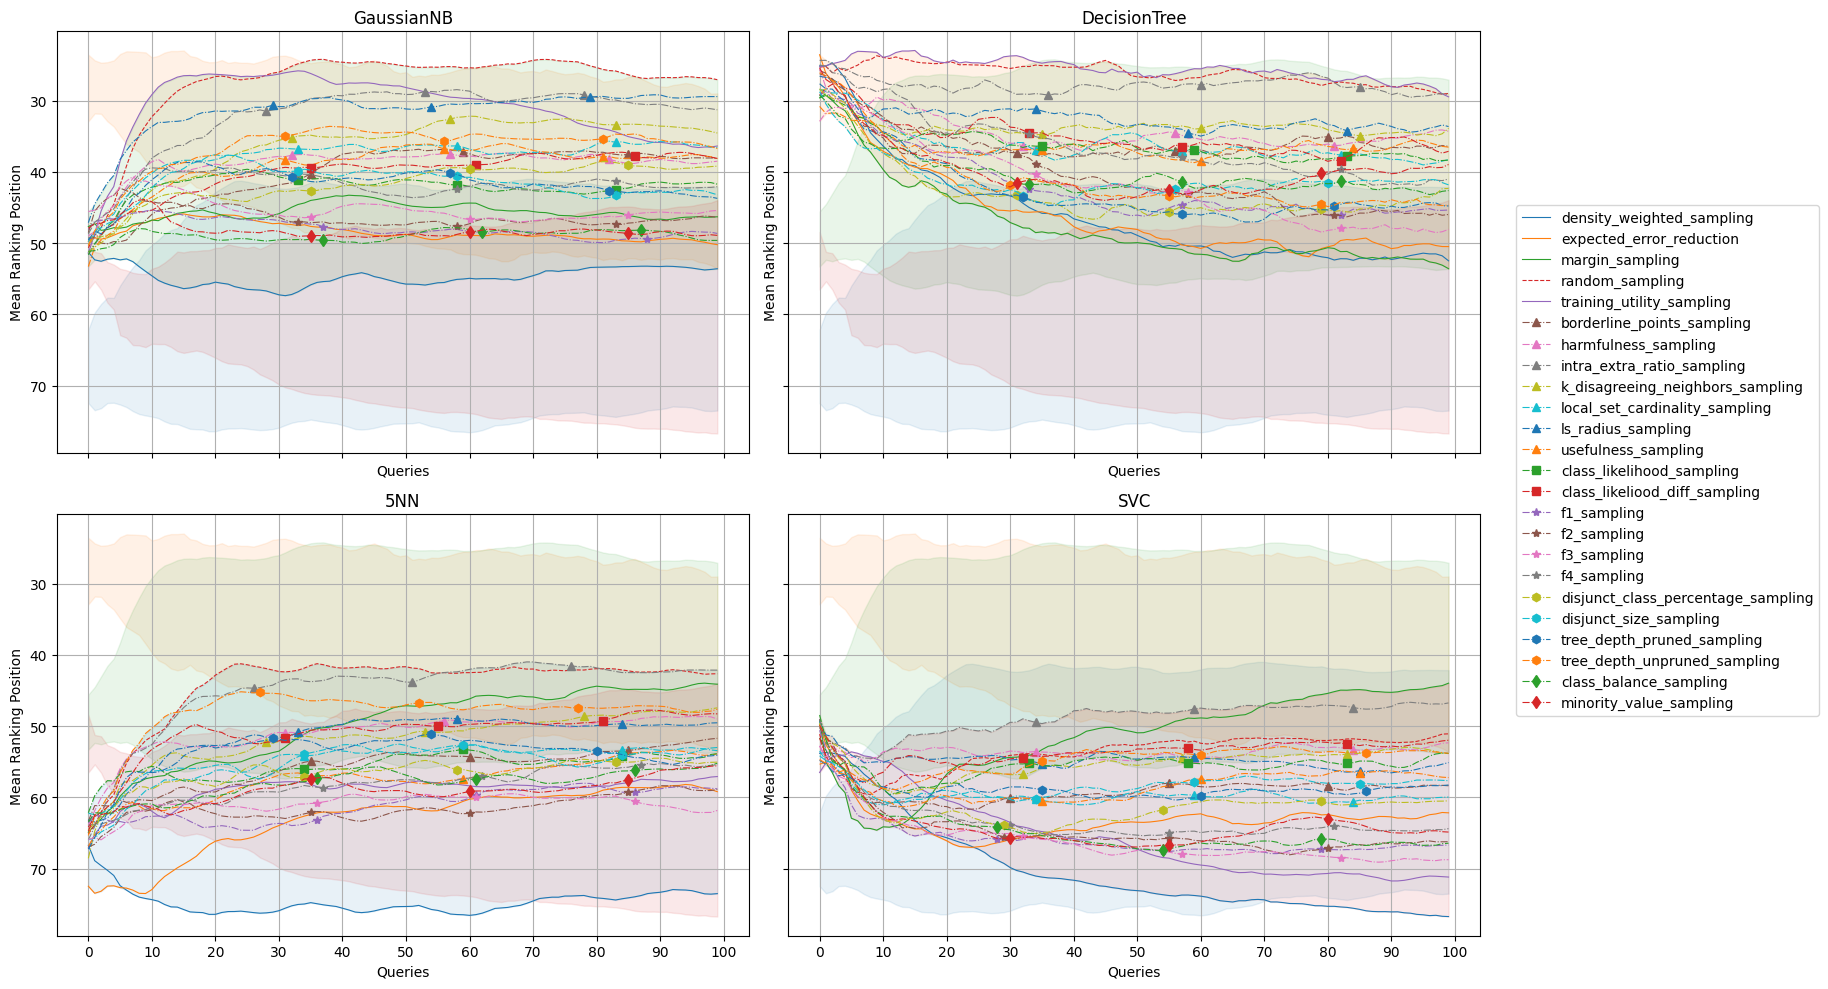

In [152]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(15, 10), sharex=True)

for ax, model in zip(axs.flatten(), ['GaussianNB', 'DecisionTree', '5NN', 'SVC']):
    plot_ranks_with_bands(df,ax=ax, model=model, log=False)
    ax.set_title(model)
plt.tight_layout()

plt.gca().invert_yaxis()
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1.75), ncols=1)

### SVC

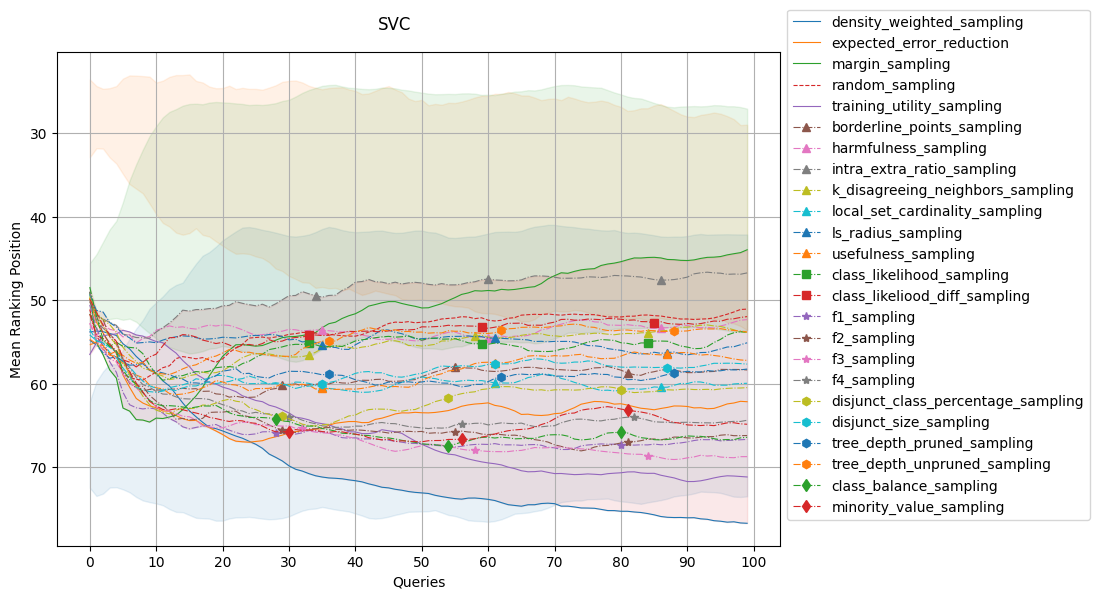

In [153]:
final_plot('SVC')

In [154]:
get_ranks_df(df,"SVC")

,strategy,group,auc_score
0,intra_extra_ratio_sampling,Neighbor-based,29.404341
1,margin_sampling,Classic,28.508285
2,random_sampling,Classic,27.936533
3,tree_depth_unpruned_sampling,Tree-based,27.494086
4,ls_radius_sampling,Neighbor-based,27.322806
5,class_likeliood_diff_sampling,Likelihood-based,27.288752
6,harmfulness_sampling,Neighbor-based,27.224661
7,k_disagreeing_neighbors_sampling,Neighbor-based,26.725875
8,class_likelihood_sampling,Likelihood-based,25.797281
9,usefulness_sampling,Neighbor-based,24.907728


### KNN

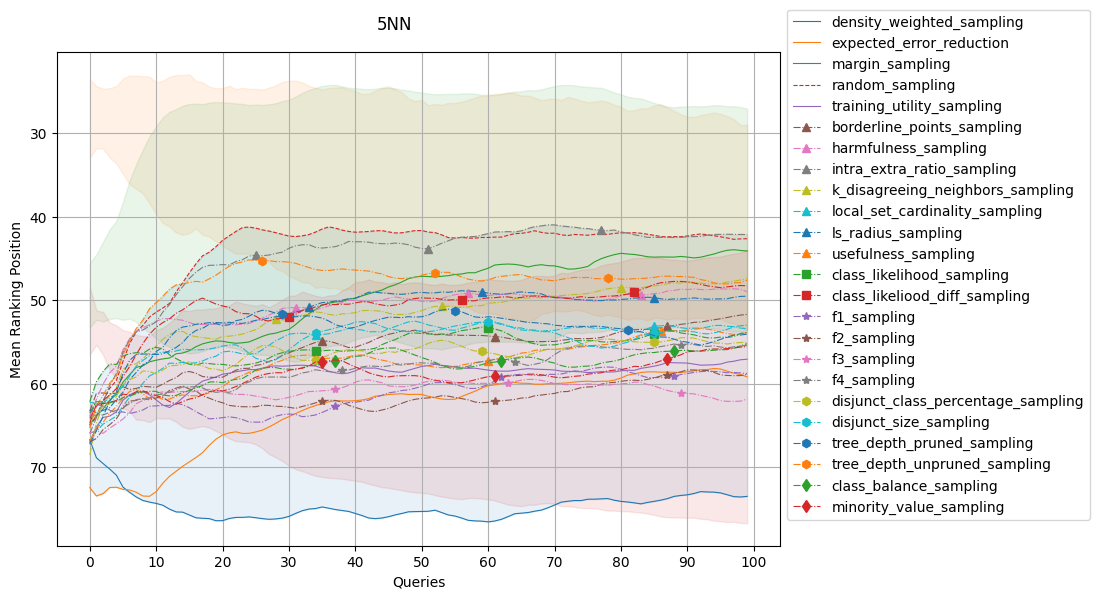

In [155]:
final_plot('5NN')

In [156]:
get_ranks_df(df,"5NN")

,strategy,group,auc_score
0,random_sampling,Classic,31.262054
1,intra_extra_ratio_sampling,Neighbor-based,30.474639
2,tree_depth_unpruned_sampling,Tree-based,29.135219
3,margin_sampling,Classic,28.535460
4,class_likeliood_diff_sampling,Likelihood-based,27.947248
5,harmfulness_sampling,Neighbor-based,27.484571
6,ls_radius_sampling,Neighbor-based,26.784671
7,k_disagreeing_neighbors_sampling,Neighbor-based,26.596990
8,tree_depth_pruned_sampling,Tree-based,26.155355
9,local_set_cardinality_sampling,Neighbor-based,25.197906


### Decision Tree

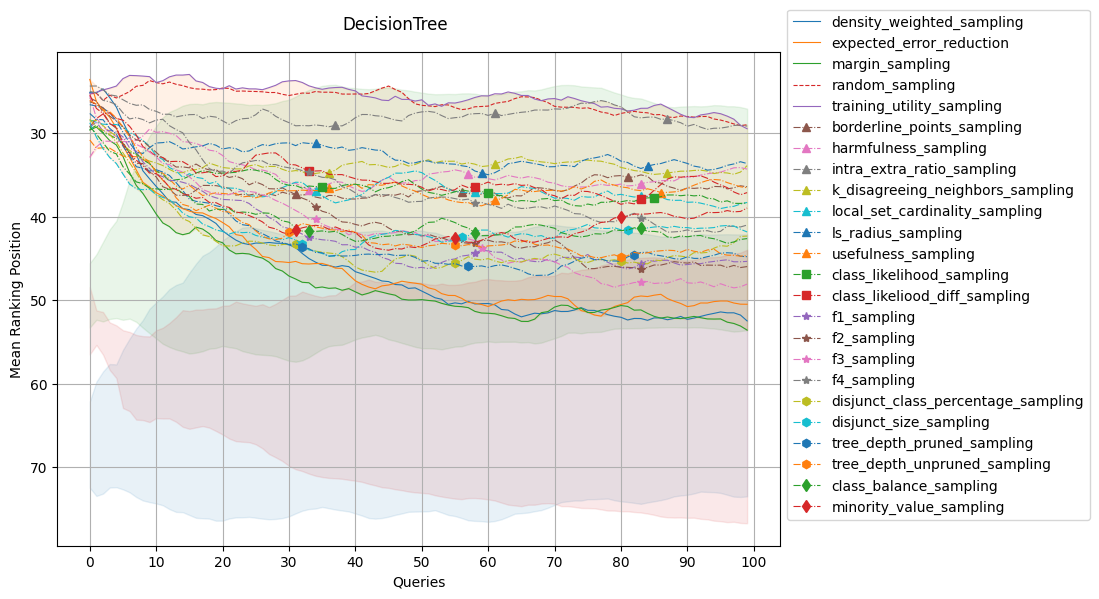

In [157]:
final_plot('DecisionTree')

In [158]:
get_ranks_df(df,"DecisionTree")

,strategy,group,auc_score
0,random_sampling,Classic,40.457219
1,training_utility_sampling,Classic,40.449908
2,intra_extra_ratio_sampling,Neighbor-based,39.501617
3,ls_radius_sampling,Neighbor-based,37.571069
4,k_disagreeing_neighbors_sampling,Neighbor-based,36.894017
5,harmfulness_sampling,Neighbor-based,36.708688
6,class_likeliood_diff_sampling,Likelihood-based,35.364008
7,borderline_points_sampling,Neighbor-based,35.005666
8,usefulness_sampling,Neighbor-based,34.990353
9,class_likelihood_sampling,Likelihood-based,34.957202


### Gaussian NB

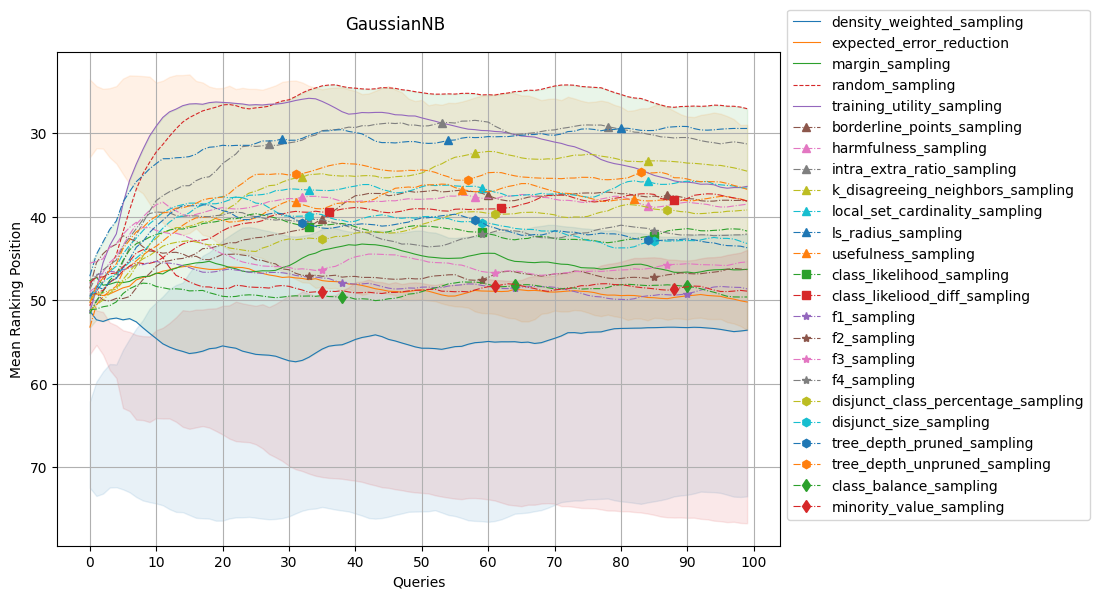

In [159]:
final_plot("GaussianNB")

In [160]:
get_ranks_df(df,"GaussianNB")

,strategy,group,auc_score
0,random_sampling,Classic,39.118018
1,intra_extra_ratio_sampling,Neighbor-based,37.206710
2,training_utility_sampling,Classic,36.574576
3,ls_radius_sampling,Neighbor-based,36.107765
4,tree_depth_unpruned_sampling,Tree-based,35.084818
5,k_disagreeing_neighbors_sampling,Neighbor-based,34.913712
6,local_set_cardinality_sampling,Neighbor-based,33.475717
7,harmfulness_sampling,Neighbor-based,33.457233
8,usefulness_sampling,Neighbor-based,32.951906
9,borderline_points_sampling,Neighbor-based,32.329053


## Comparação de Categorias

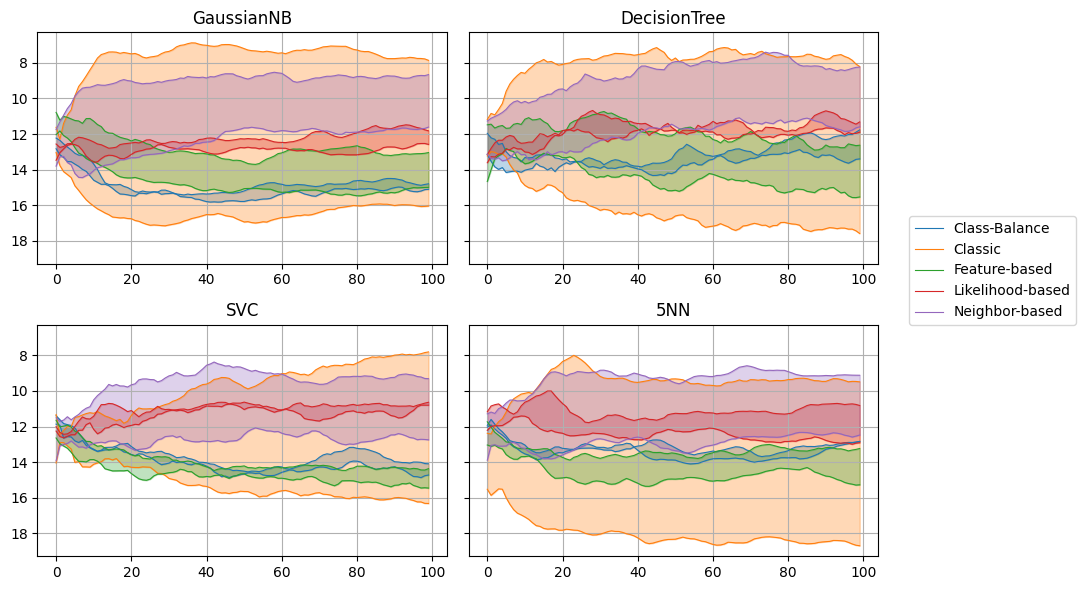

In [161]:
plot_group_bands(df)
plt.gca().invert_yaxis()

## Tabelas

In [162]:
df

,,,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
dataset,model,strategy,,,,,,,,,,,,,,,,,,,,,
eeg-eye-state,GaussianNB,class_balance_sampling,0.003512,0.003915,0.004411,0.010703,0.003521,0.002941,0.004238,0.004994,0.010709,0.020971,...,0.020672,0.020146,0.020499,0.020528,0.020747,0.021082,0.021168,0.021046,0.021456,0.021969
mushroom,DecisionTree,k_disagreeing_neighbors_sampling,0.262291,0.334616,0.401433,0.283874,0.205856,0.321085,0.344040,0.263190,0.396457,0.381041,...,0.817003,0.802230,0.758182,0.765232,0.783358,0.798360,0.848931,0.841065,0.840466,0.842447
wine,SVC,class_balance_sampling,0.259173,0.280686,0.304490,0.305220,0.305707,0.291346,0.273008,0.305220,0.314723,0.314723,...,0.480031,0.480031,0.480031,0.488590,0.488590,0.488590,0.488590,0.488590,0.478734,0.478734
thyroid-hypothyroid,SVC,margin_sampling,0.451444,0.554136,0.494053,0.574862,0.538562,0.561096,0.582577,0.687633,0.617619,0.603892,...,0.706740,0.699937,0.710493,0.682342,0.685288,0.645773,0.676738,0.647334,0.670364,0.687944
cardiotocography-3class,5NN,random_sampling,0.023885,0.028834,0.025332,0.036200,0.031094,0.021340,0.021340,0.021340,0.018251,0.028161,...,0.070260,0.070949,0.069170,0.068352,0.068123,0.068123,0.075283,0.075283,0.074500,0.074500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yeast-4class,5NN,f2_sampling,-0.001569,0.006101,0.030874,0.044749,0.053640,0.083463,0.106021,0.114850,0.131927,0.140830,...,0.374250,0.373034,0.372978,0.374383,0.372075,0.369895,0.373374,0.373742,0.367942,0.355559
volcanoes-a3,5NN,usefulness_sampling,0.004229,0.022997,0.017528,0.037270,0.043939,0.048653,0.042494,0.049594,0.056729,0.052256,...,0.059635,0.059635,0.075762,0.075762,0.075762,0.075762,0.075762,0.075762,0.076762,0.077976
thyroid-hypothyroid,DecisionTree,random_sampling,0.395769,0.700852,0.639873,0.265055,0.525975,0.398246,0.679335,0.585641,0.574087,0.695632,...,0.698485,0.693814,0.669173,0.699875,0.696443,0.688868,0.705686,0.681565,0.652754,0.699496


In [169]:
ranked_df = df.groupby('dataset').rank(ascending=False)
# ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

# auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

model  strategy                     
5NN    borderline_points_sampling       55.493389
       class_balance_sampling           57.839833
       class_likelihood_sampling        55.365667
       class_likeliood_diff_sampling    50.635333
       density_weighted_sampling        74.757444
                                          ...    
SVC    random_sampling                  53.612500
       training_utility_sampling        65.916389
       tree_depth_pruned_sampling       58.987056
       tree_depth_unpruned_sampling     54.720000
       usefulness_sampling              58.502611
Length: 96, dtype: float64

In [218]:
table = ranked_df.groupby(['model', 'strategy']).apply(lambda x: x.stack().mean())
table_sorted = table.sort_values().reset_index()
table_sorted['group'] = table_sorted.strategy.apply(get_hm_type)
table_sorted.model = table_sorted.model.apply(lambda x: ABREV_MODEL[x])
table_sorted.strategy = table_sorted.strategy.apply(lambda x: ABREV_DICT[x])
table_sorted = table_sorted[[0, 'model', 'strategy', 'group']]
table_sorted

,0,model,strategy,group
0,25.653222,CART,TU,Classic
1,26.175444,CART,Rnd,Classic
2,27.093500,NB,Rnd,Classic
3,27.880611,CART,N2I,Neighbor-based
4,30.788000,NB,TU,Classic
...,...,...,...,...
91,65.916389,SVM,TU,Classic
92,66.090000,SVM,F1I,Feature-based
93,66.393611,SVM,F3I,Feature-based
94,70.767556,SVM,ID,Classic


In [219]:
header = ['Rank Pos.', 'Learner', 'Method', 'Group']
table_sorted[:48].to_latex(index=False, buf=open('table_rank.tex', 'w'), float_format="%.2f", header=header)
table_sorted[48:].to_latex(index=False, buf=open('table_rank.tex', 'a'), float_format="%.2f", header=header)

In [235]:
header = ['Rank Pos.', 'Method', 'Group']
for m, model_rank in table_sorted.groupby('model'):
    mid = len(model_rank)//2
    model_rank = model_rank.drop(columns='model')
    model_rank[mid:].to_latex( buf=open(f'table_rank_{m}.tex', 'w'), float_format="%.2f", header=header, index=False)
    model_rank[:mid].to_latex( buf=open(f'table_rank_{m}.tex', 'a'), float_format="%.2f", header=header, index=False)
    